In [1]:
import copy
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)    
matplotlib.rcParams['axes.unicode_minus'] = False      
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 150)

from xgboost import XGBRegressor

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.set_printoptions(sci_mode=False)
random_seed = 616

### 기본 데이터

In [2]:
y_col = '유입량'
PK_col = ['홍수사상번호','연','월','일','시간']

In [3]:
data_raw = pd.read_excel('../data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])
data_raw = data_raw.dropna()

data_raw.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in data_raw.columns.values]

In [4]:
# 결과 값 저장할 dataframe 생성

predict_df = pd.DataFrame()
predict_df[PK_col] = data_raw[PK_col]
predict_df['true'] = data_raw.유입량

rmse_df = pd.DataFrame()

## source code

In [5]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layer=(1, 1, 1), batch_norm=True, drop_out=True, drop_prob=0.3):
        super().__init__()
        self.hidden_layer = self.make_layers(input_size, hidden_layer, batch_norm, drop_out, drop_prob)

    def forward(self, x):
        out = self.hidden_layer(x)
        return out

    def make_layers(self, input_size, hidden_layer, batch_norm, drop_out, drop_prob):
        layers = []
        in_size = input_size
        if hidden_layer[0] == 'R':
            for v in hidden_layer[1:]:
                out_size = int(v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size
        else:
            for v in hidden_layer:
                out_size = int(input_size * v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size

        linear = nn.Linear(out_size, 1)
        torch.nn.init.xavier_uniform_(linear.weight)
        layers += [linear]

        return nn.Sequential(*layers)

In [6]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [104]:
first_values = data_raw.groupby('홍수사상번호').first()['유입량']

def dnn_predict(name, data, model_structure, scaler, view=False, view_num=5, early_stop_num = 3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device
    pred_values = []
    predict_df = pd.DataFrame()
    predict_df[PK_col] = data[['홍수사상번호','연','월','일','시간']]
    predict_df['true'] = data.유입량
    
    for num in data.홍수사상번호.unique():
        print(f"홍수사상번호 {num} 시작")
        train = data[data['홍수사상번호'] != num].dropna().copy()
        valid = data[data['홍수사상번호'] == num].copy()

        X_train = train.drop(columns=[y_col]+PK_col)
        y_train = train[y_col]

        X_valid = valid.drop(columns=[y_col]+PK_col)
        y_valid = valid[y_col]
        
        scaler.fit(X_train)

        X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
        X_valid_tensors = torch.Tensor(scaler.transform(X_valid)).to(device)

        y_train_tensors = torch.Tensor(y_train.values).to(device)
        y_valid_tensors = torch.Tensor(y_valid.values).to(device)
        
        input_size = X_train.shape[1]

        dnn = DNN(input_size, model_structure["hidden_layer"], model_structure["batch_norm"],
                  model_structure["drop_out"], model_structure["drop_prob"]).to(device)
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(dnn.parameters(), lr=model_structure["learning_rate"])  # adam optimizer
        
        best_loss = 1E+10
        best_epoch = 0
        for epoch in range(model_structure["num_epochs"]):
            optimizer.zero_grad()
            outputs = dnn(X_train_tensors)
            loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                dnn.eval()
                outputs_valid = dnn(X_valid_tensors)
                loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
                if loss_valid < best_loss:
                    best_loss = loss_valid
                    best_epoch = epoch
                    pred_valid = list(outputs_valid.view(-1).detach().cpu().numpy())
                dnn.train()

            if view and ((epoch+1) % (model_structure["num_epochs"]//view_num) == 0):
                print("  Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))
            
            if (epoch - best_epoch) > (model_structure["num_epochs"] // early_stop_num):
                print("Best Epoch: %d Best Valid Loss: %1.2f" % (best_epoch+1, best_loss.item()))
                break
        print("")
        pred_values += pred_valid
    
    predict_df[f'pred_{name}'] = pred_values
    predict_df[f'error_{name}'] = abs(predict_df['true'] - predict_df[f'pred_{name}'])
    predict_df[f'error_percent_{name}'] = predict_df[f'error_{name}'] / predict_df['true'] * 100

    rmse = np.sqrt(mean_squared_error(predict_df['true'], predict_df[f'pred_{name}']))
    
    return predict_df, rmse

In [105]:
def plot_hongsunum(predict_df, name):
    for idx in predict_df['홍수사상번호'].unique():
        plt.figure(figsize=(12,4))
        predict_df.loc[predict_df['홍수사상번호'] ==idx]['true'].plot(label='True')
        predict_df.loc[predict_df['홍수사상번호'] ==idx][f'pred_{name}'].plot(label=name)
        plt.legend()
        plt.title(f"{name}_{idx}")
        plt.show()

# Predict

In [108]:
name = 'base'
model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

data_base = data_raw.copy()

In [109]:
predict_df, rmse = dnn_predict(name, data_base, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 988 Best Valid Loss: 1321260.50

홍수사상번호 2 시작
Best Epoch: 940 Best Valid Loss: 711754.38

홍수사상번호 3 시작
Best Epoch: 470 Best Valid Loss: 39598.09

홍수사상번호 4 시작
Best Epoch: 3834 Best Valid Loss: 126674.95

홍수사상번호 5 시작
Best Epoch: 1523 Best Valid Loss: 1066944.62

홍수사상번호 6 시작
Best Epoch: 3692 Best Valid Loss: 56785.82

홍수사상번호 7 시작
Best Epoch: 562 Best Valid Loss: 341654.47

홍수사상번호 8 시작
Best Epoch: 1577 Best Valid Loss: 485705.97

홍수사상번호 9 시작
Best Epoch: 710 Best Valid Loss: 93737.52

홍수사상번호 10 시작
Best Epoch: 657 Best Valid Loss: 50043.14

홍수사상번호 11 시작
Best Epoch: 1315 Best Valid Loss: 58856.65

홍수사상번호 12 시작
Best Epoch: 793 Best Valid Loss: 48584.22

홍수사상번호 13 시작
Best Epoch: 659 Best Valid Loss: 68825.72

홍수사상번호 14 시작
Best Epoch: 3048 Best Valid Loss: 188093.56

홍수사상번호 15 시작
Best Epoch: 3167 Best Valid Loss: 47839.48

홍수사상번호 16 시작
Best Epoch: 490 Best Valid Loss: 38794.64

홍수사상번호 17 시작
Best Epoch: 1216 Best Valid Loss: 191655.86

홍수사상번호 18 시작
Best Epoch: 595 Best Valid

In [110]:
predict_df

,홍수사상번호,연,월,일,시간,true,pred_base,error_base,error_percent_base
0,1,2006,7,10,8,189.10,133.20,55.90,29.56
1,1,2006,7,10,9,216.95,151.72,65.24,30.07
2,1,2006,7,10,10,251.42,160.39,91.04,36.21
3,1,2006,7,10,11,302.81,219.50,83.31,27.51
4,1,2006,7,10,12,384.78,264.60,120.18,31.23
...,...,...,...,...,...,...,...,...,...
2886,25,2017,7,18,18,513.37,461.04,52.33,10.19
2887,25,2017,7,18,19,502.85,458.43,44.41,8.83
2888,25,2017,7,18,20,491.95,454.07,37.89,7.70
2889,25,2017,7,18,21,481.10,445.39,35.71,7.42


In [111]:
rmse_df.loc[name, "RMSE"] = rmse
rmse_df

,RMSE
base,502.05
mean,1427.26
mean_586,1403.63


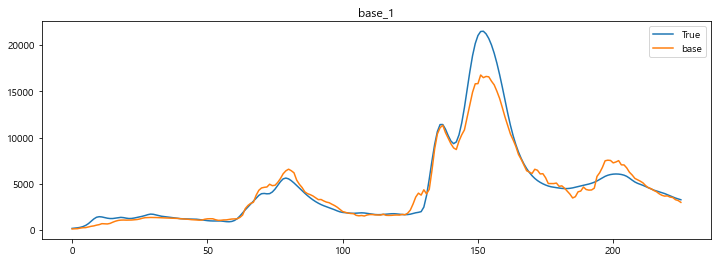

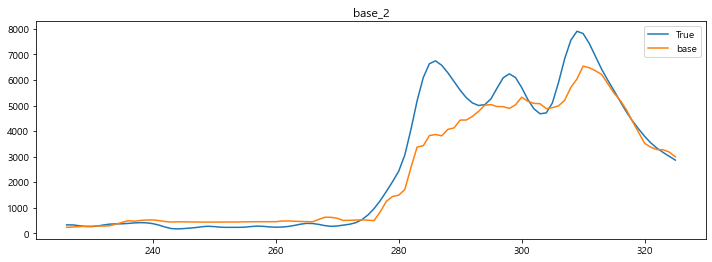

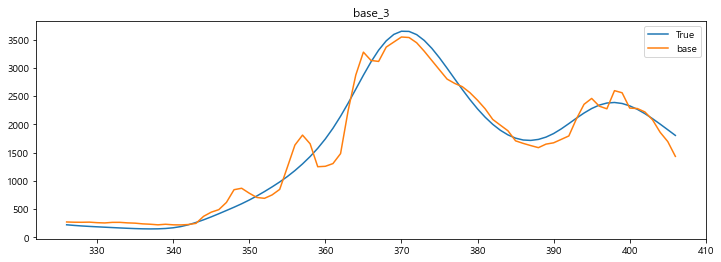

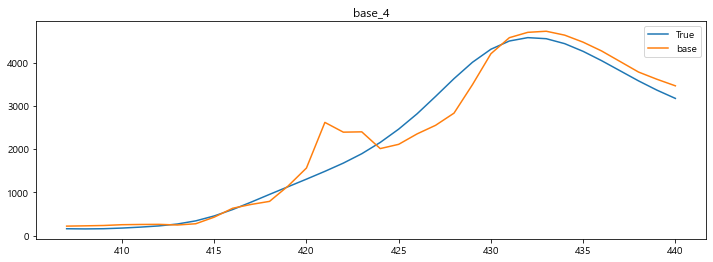

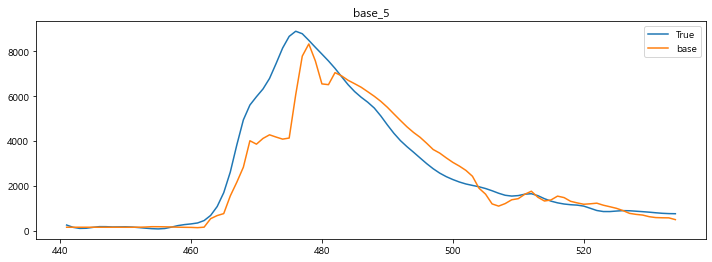

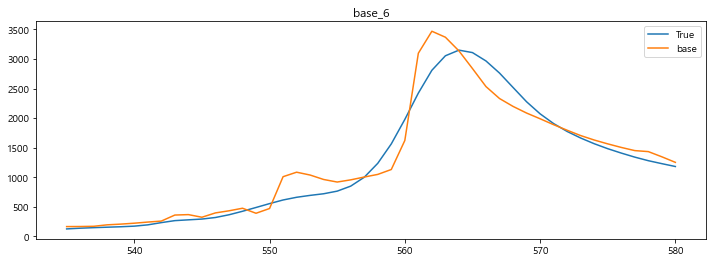

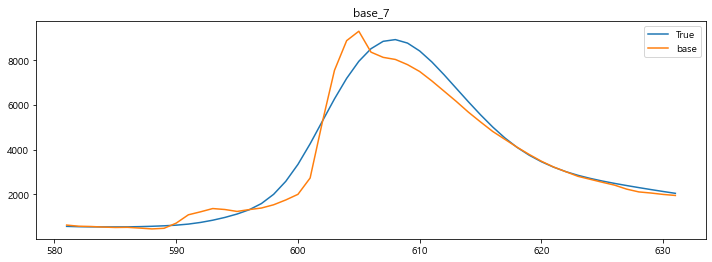

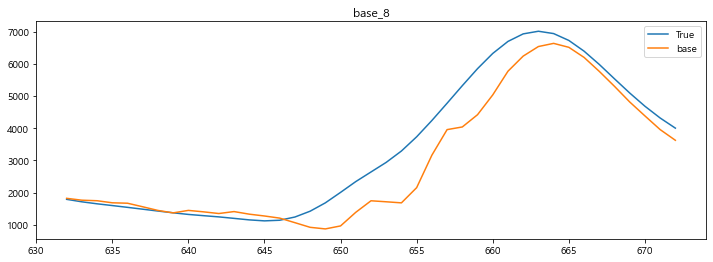

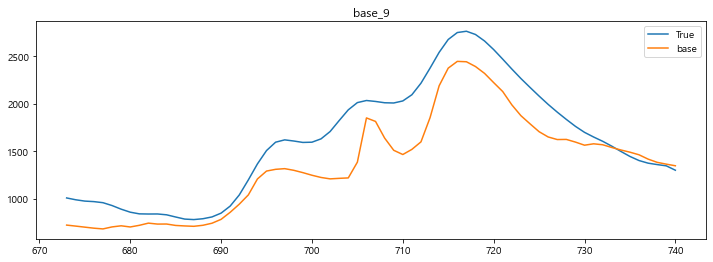

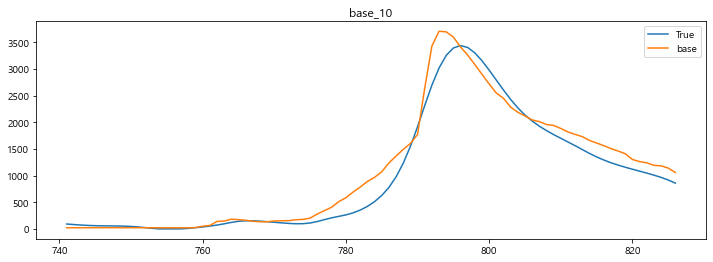

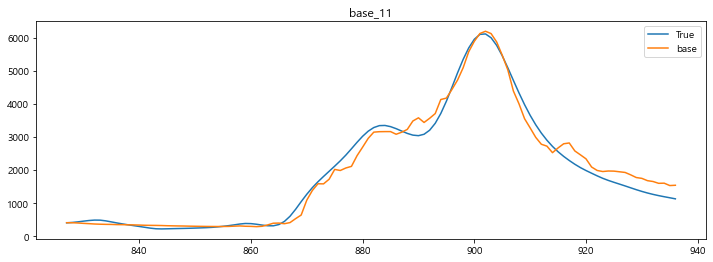

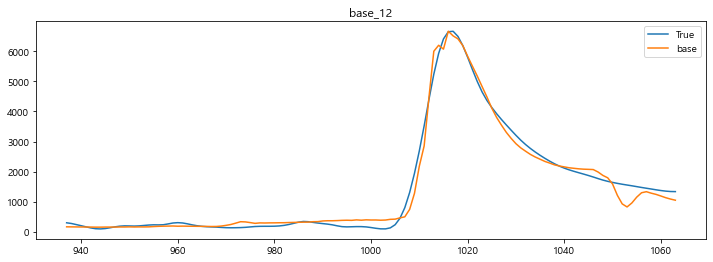

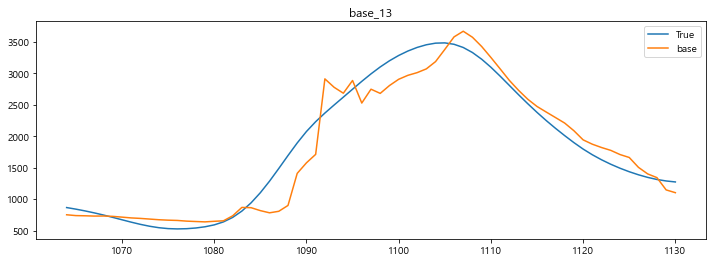

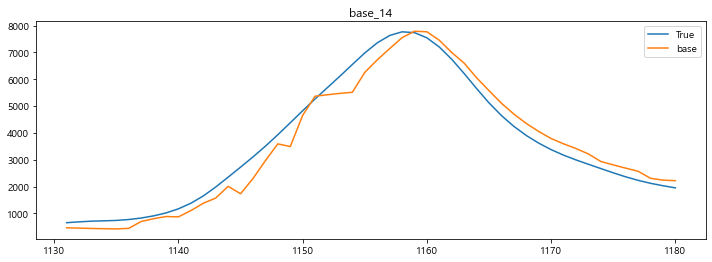

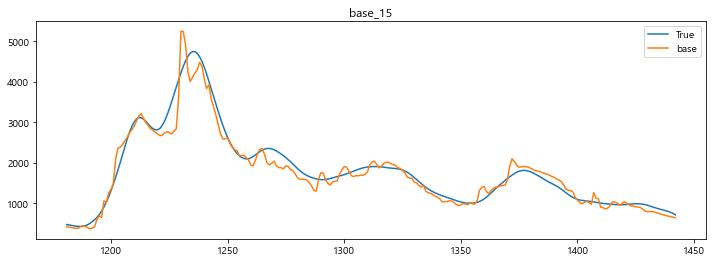

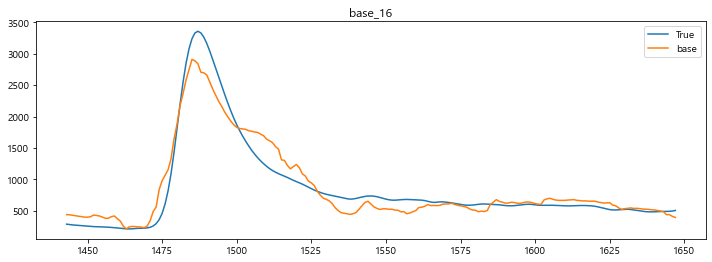

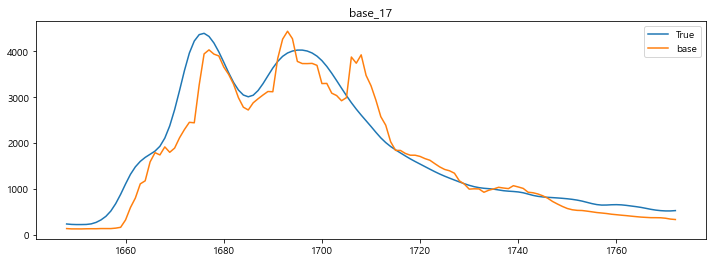

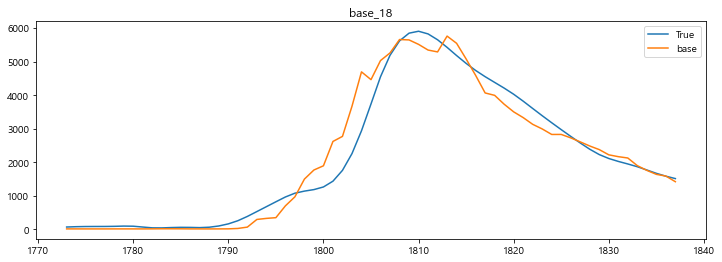

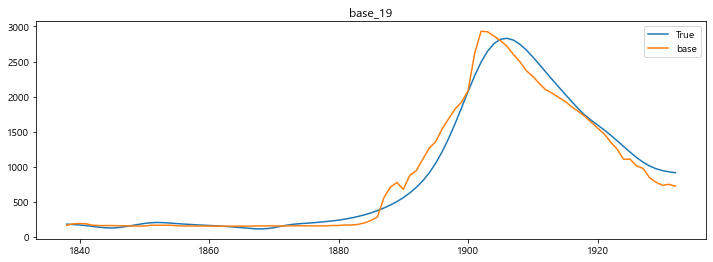

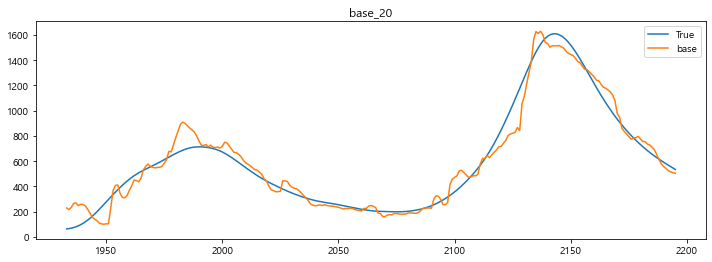

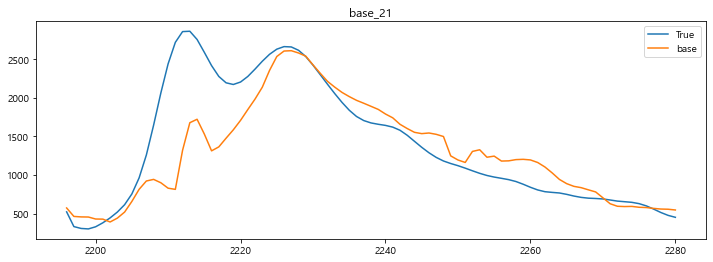

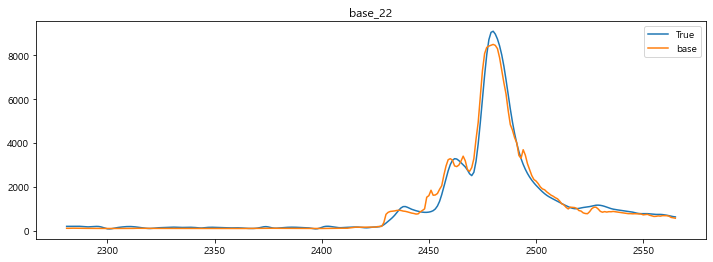

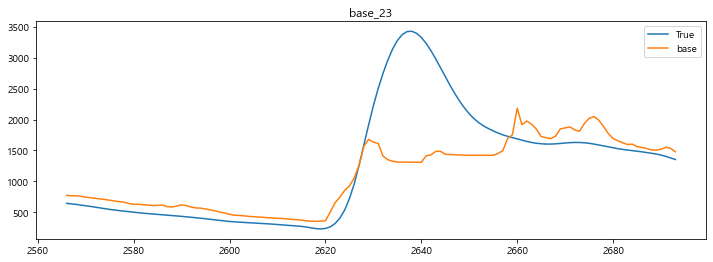

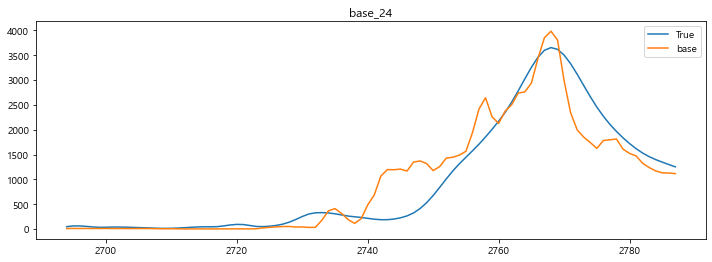

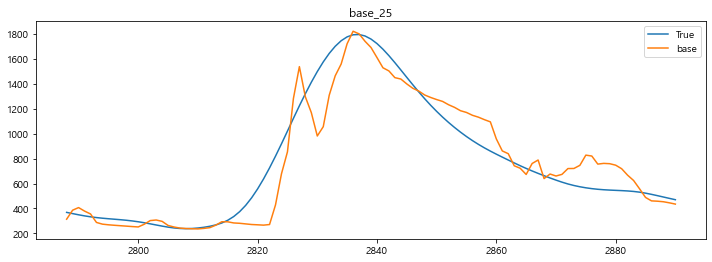

In [112]:
plot_hongsunum(predict_df, name)

# Predict_ 21 23 제외

In [129]:
name = 'base_2123'
model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

data_2123 = data_raw[~data_raw.홍수사상번호.isin([21,23])].copy()

In [130]:
predict_df, rmse = dnn_predict(name, data_2123, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1 시작
Best Epoch: 619 Best Valid Loss: 1323339.62

홍수사상번호 2 시작
Best Epoch: 741 Best Valid Loss: 862177.81

홍수사상번호 3 시작
Best Epoch: 510 Best Valid Loss: 53491.98

홍수사상번호 4 시작
Best Epoch: 880 Best Valid Loss: 150189.20

홍수사상번호 5 시작
Best Epoch: 824 Best Valid Loss: 1023811.88

홍수사상번호 6 시작
Best Epoch: 881 Best Valid Loss: 49531.55

홍수사상번호 7 시작
Best Epoch: 502 Best Valid Loss: 309188.00

홍수사상번호 8 시작
Best Epoch: 678 Best Valid Loss: 526207.56

홍수사상번호 9 시작
Best Epoch: 886 Best Valid Loss: 47316.54

홍수사상번호 10 시작
Best Epoch: 585 Best Valid Loss: 30339.13

홍수사상번호 11 시작
Best Epoch: 970 Best Valid Loss: 53854.27

홍수사상번호 12 시작
Best Epoch: 1073 Best Valid Loss: 67191.75

홍수사상번호 13 시작
Best Epoch: 815 Best Valid Loss: 69822.31

홍수사상번호 14 시작
Best Epoch: 1173 Best Valid Loss: 222129.53

홍수사상번호 15 시작
Best Epoch: 955 Best Valid Loss: 47639.18

홍수사상번호 16 시작
Best Epoch: 499 Best Valid Loss: 12982.78

홍수사상번호 17 시작
Best Epoch: 858 Best Valid Loss: 195644.56

홍수사상번호 18 시작
Best Epoch: 729 Best Valid Loss:

In [131]:
predict_df

,홍수사상번호,연,월,일,시간,true,pred_base_2123,error_base_2123,error_percent_base_2123
0,1,2006,7,10,8,189.10,130.93,58.17,30.76
1,1,2006,7,10,9,216.95,155.01,61.94,28.55
2,1,2006,7,10,10,251.42,165.55,85.88,34.16
3,1,2006,7,10,11,302.81,230.18,72.63,23.99
4,1,2006,7,10,12,384.78,270.61,114.18,29.67
...,...,...,...,...,...,...,...,...,...
2886,25,2017,7,18,18,513.37,416.90,96.47,18.79
2887,25,2017,7,18,19,502.85,435.81,67.03,13.33
2888,25,2017,7,18,20,491.95,437.40,54.56,11.09
2889,25,2017,7,18,21,481.10,429.46,51.65,10.73


In [132]:
rmse_df.loc[name, "RMSE"] = rmse
rmse_df

,RMSE
base,505.67
mean,1128.37
mean_586,1116.86
base_2123,496.99


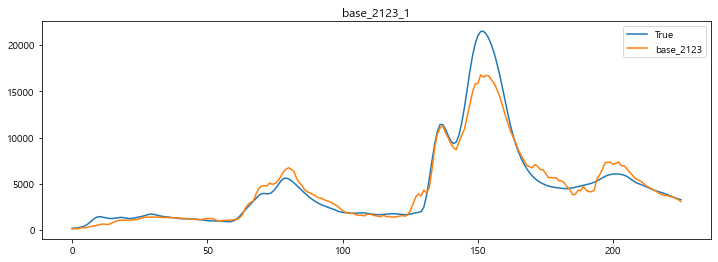

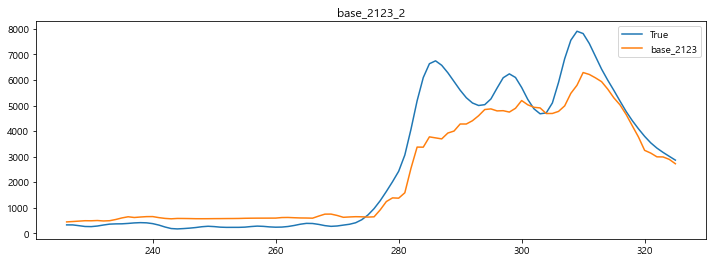

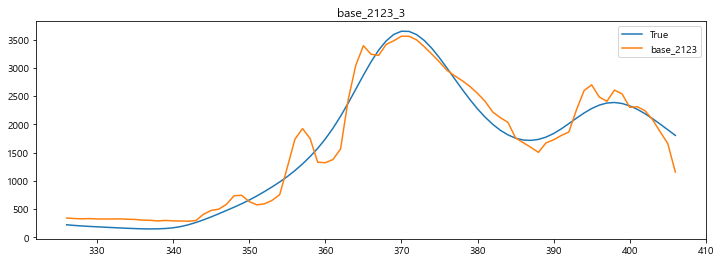

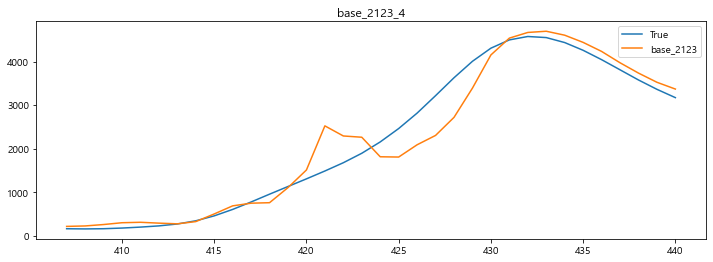

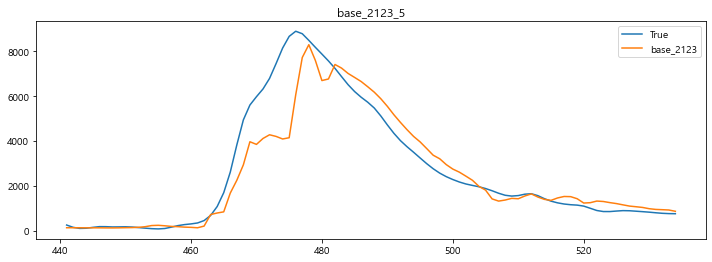

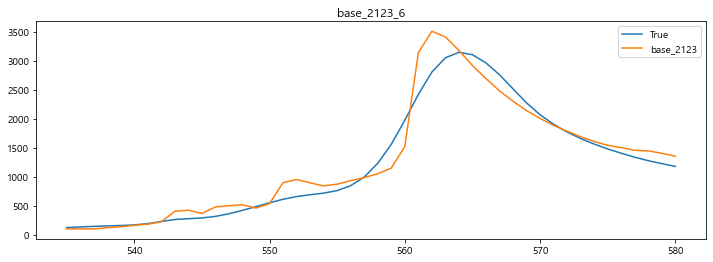

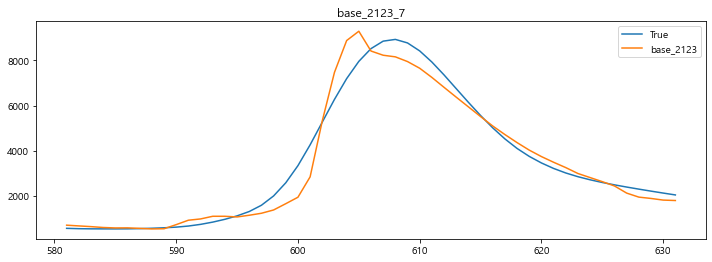

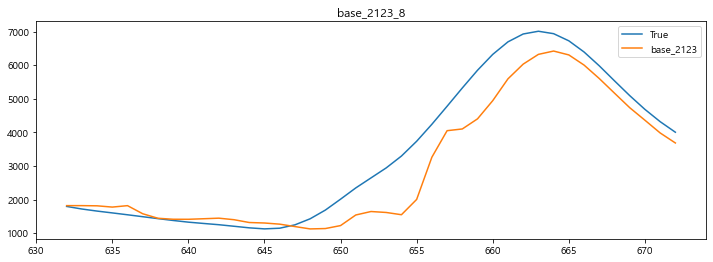

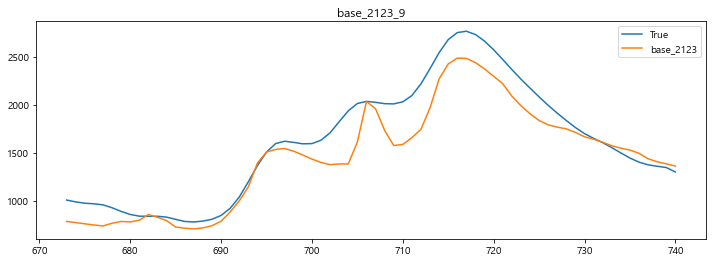

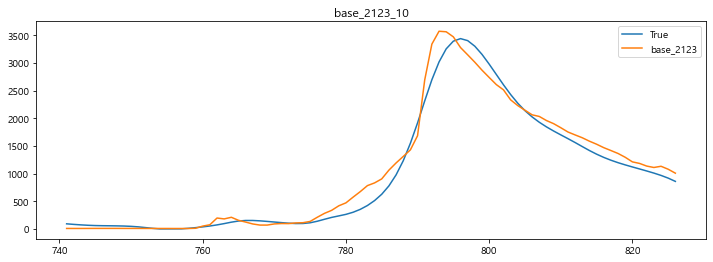

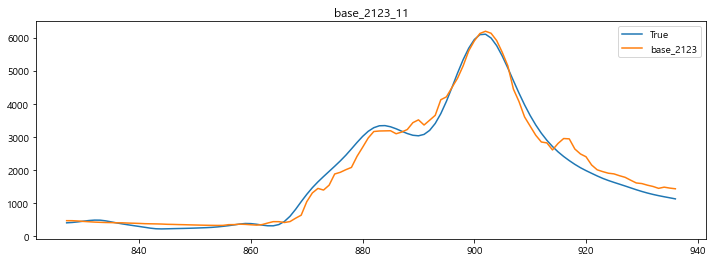

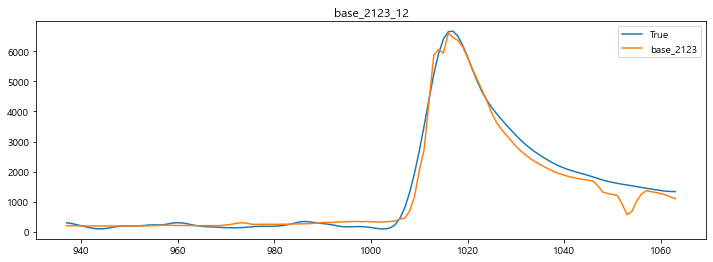

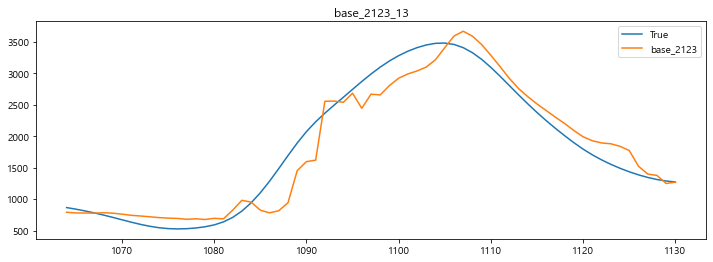

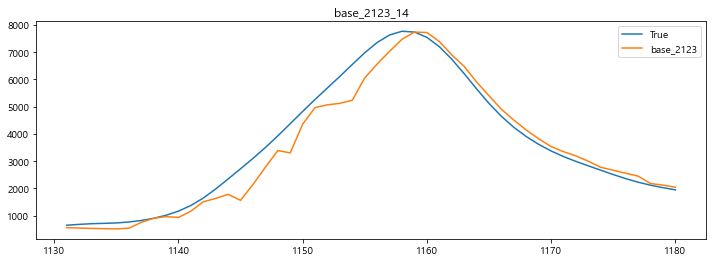

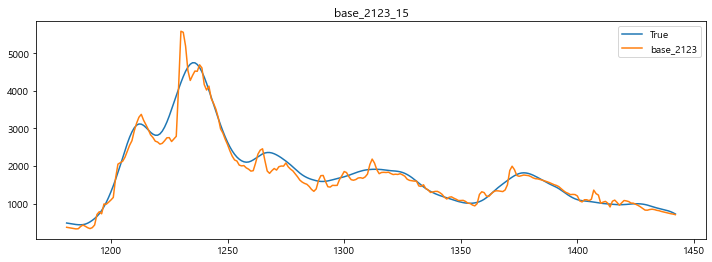

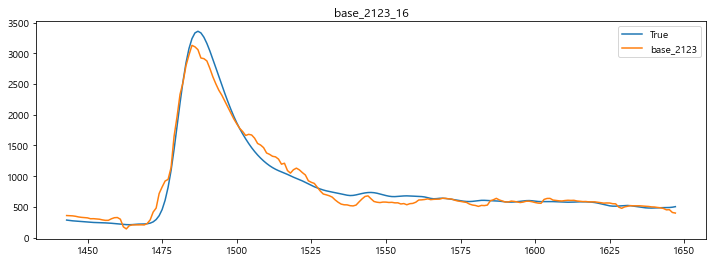

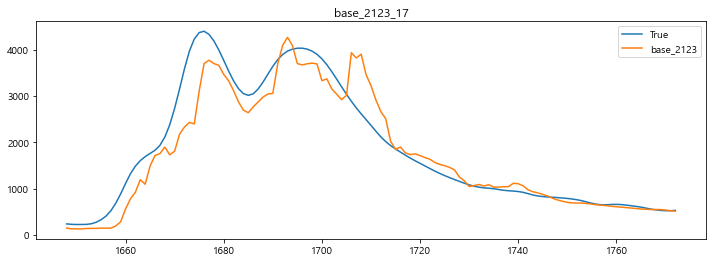

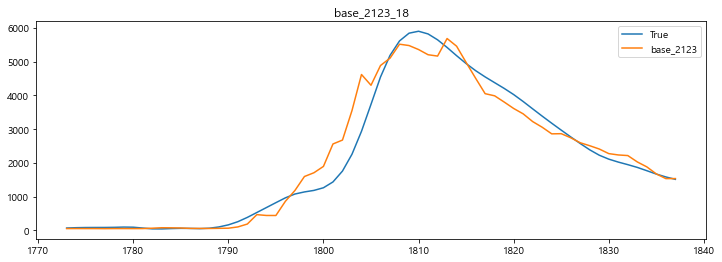

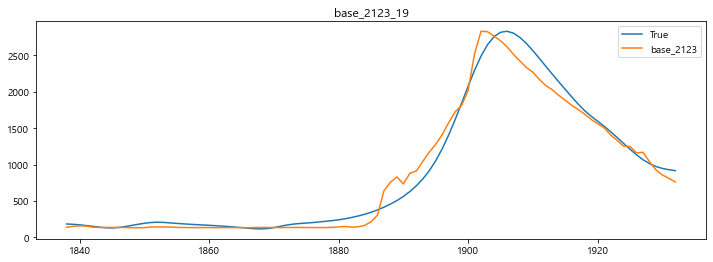

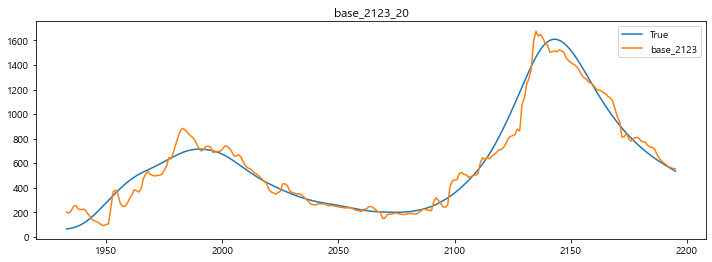

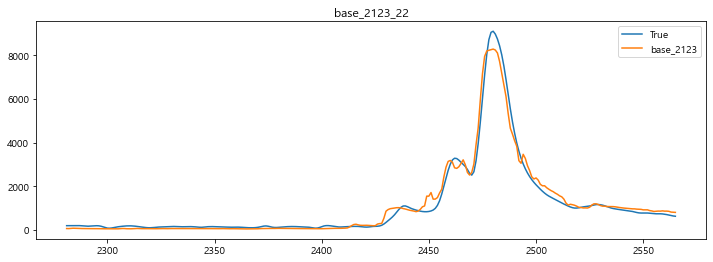

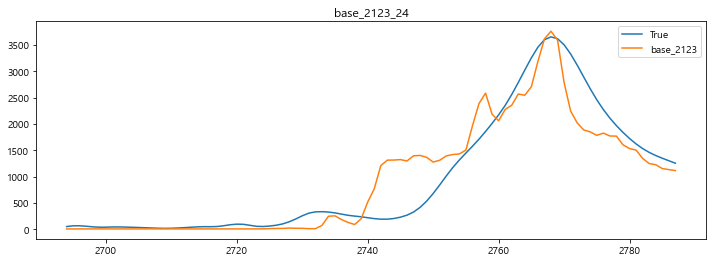

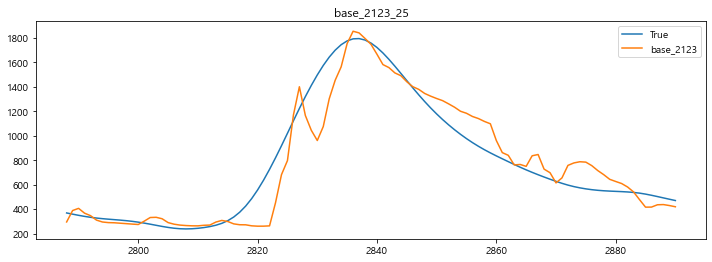

In [133]:
plot_hongsunum(predict_df, name)

## 데이터집단 평균 사용

In [113]:
name = 'mean'

model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

data_one = pd.read_excel('../data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])
data_one = data_one.dropna()
data_one.columns = [col[1] if "Unnamed" not in col[1] else col[0] for col in data_one.columns.values]
data_one = data_one.groupby(by=data_one.columns, axis=1).mean()

In [114]:
predict_df, rmse = dnn_predict(name, data_one, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1.0 시작
Best Epoch: 2692 Best Valid Loss: 10612923.00

홍수사상번호 2.0 시작
Best Epoch: 2035 Best Valid Loss: 3428810.75

홍수사상번호 3.0 시작
Best Epoch: 2232 Best Valid Loss: 70376.26

홍수사상번호 4.0 시작
Best Epoch: 2699 Best Valid Loss: 465788.41

홍수사상번호 5.0 시작
Best Epoch: 2107 Best Valid Loss: 3350430.75

홍수사상번호 6.0 시작
Best Epoch: 2019 Best Valid Loss: 52229.15

홍수사상번호 7.0 시작
Best Epoch: 1833 Best Valid Loss: 1120472.88

홍수사상번호 8.0 시작
Best Epoch: 1681 Best Valid Loss: 836116.19

홍수사상번호 9.0 시작
Best Epoch: 1657 Best Valid Loss: 195112.39

홍수사상번호 10.0 시작
Best Epoch: 3293 Best Valid Loss: 44530.77

홍수사상번호 11.0 시작
Best Epoch: 2092 Best Valid Loss: 266457.38

홍수사상번호 12.0 시작
Best Epoch: 2311 Best Valid Loss: 369863.25

홍수사상번호 13.0 시작
Best Epoch: 1565 Best Valid Loss: 304427.47

홍수사상번호 14.0 시작
Best Epoch: 2233 Best Valid Loss: 1715219.38

홍수사상번호 15.0 시작
Best Epoch: 2377 Best Valid Loss: 212311.45

홍수사상번호 16.0 시작
Best Epoch: 3038 Best Valid Loss: 45130.86

홍수사상번호 17.0 시작
Best Epoch: 1892 Best Valid Loss

In [115]:
predict_df

,홍수사상번호,연,월,일,시간,true,pred_mean,error_mean,error_percent_mean
0,1.00,2006.00,7.00,10.00,8.00,189.10,16.00,173.10,91.54
1,1.00,2006.00,7.00,10.00,9.00,216.95,16.00,200.95,92.63
2,1.00,2006.00,7.00,10.00,10.00,251.42,16.00,235.43,93.64
3,1.00,2006.00,7.00,10.00,11.00,302.81,16.00,286.81,94.72
4,1.00,2006.00,7.00,10.00,12.00,384.78,16.00,368.79,95.84
...,...,...,...,...,...,...,...,...,...
2886,25.00,2017.00,7.00,18.00,18.00,513.37,539.75,26.38,5.14
2887,25.00,2017.00,7.00,18.00,19.00,502.85,514.75,11.90,2.37
2888,25.00,2017.00,7.00,18.00,20.00,491.95,505.79,13.83,2.81
2889,25.00,2017.00,7.00,18.00,21.00,481.10,500.49,19.39,4.03


In [116]:
rmse_df.loc[name, "RMSE"] = rmse
rmse_df

,RMSE
base,502.05
mean,1128.37
mean_586,1403.63


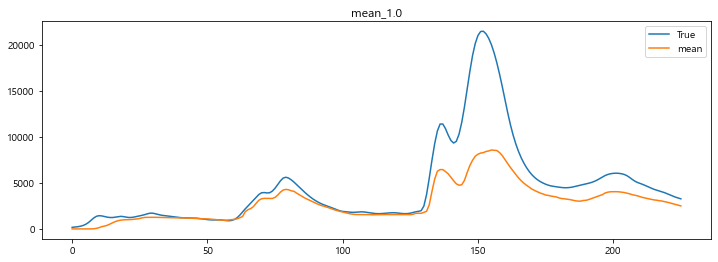

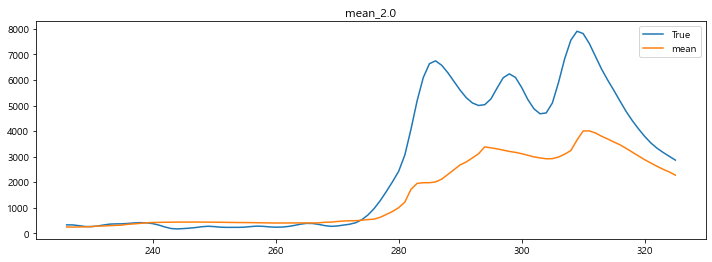

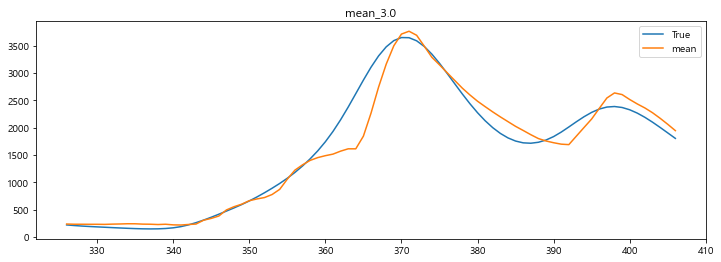

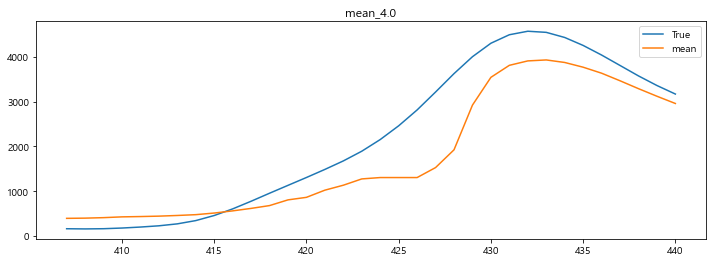

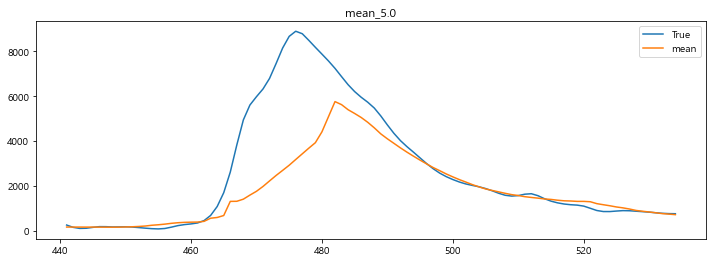

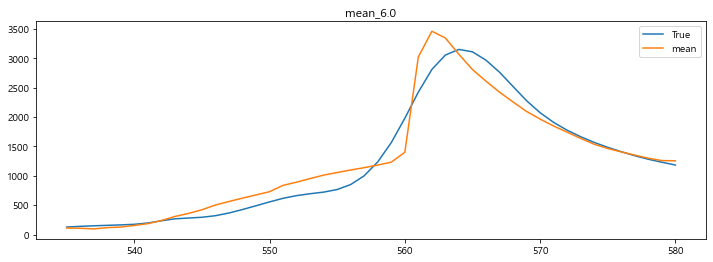

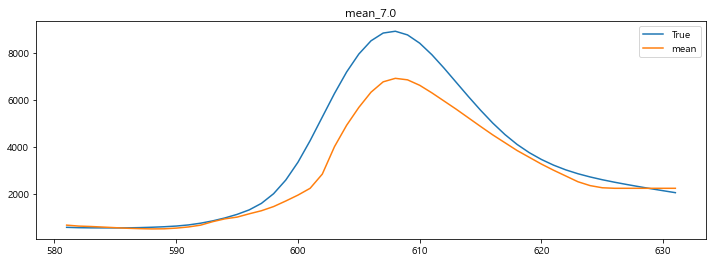

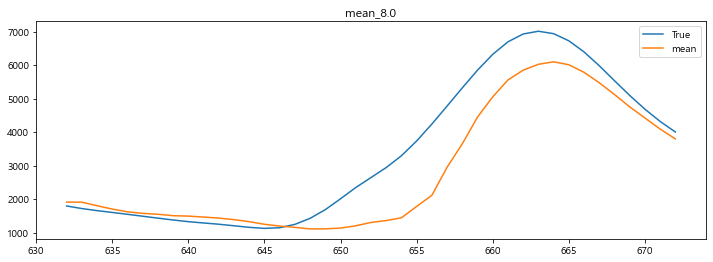

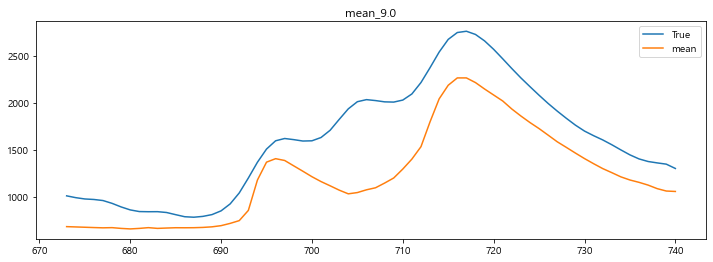

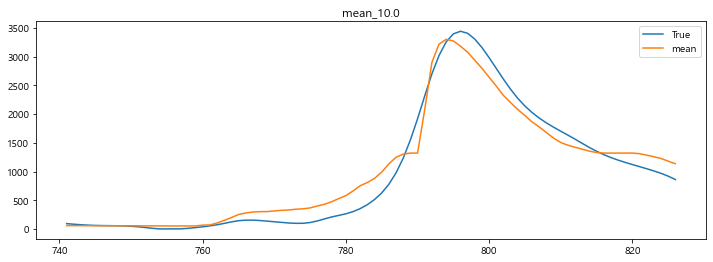

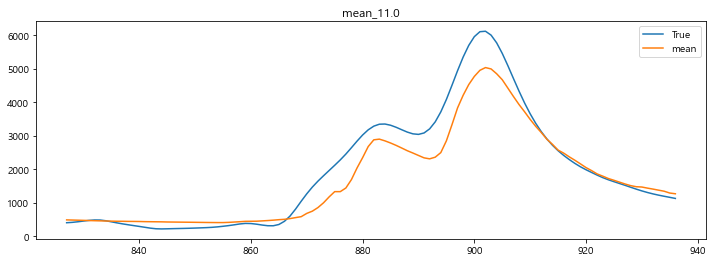

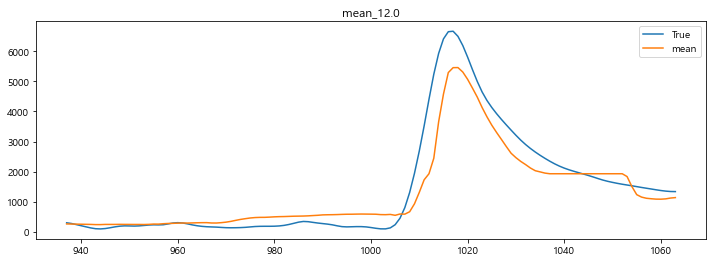

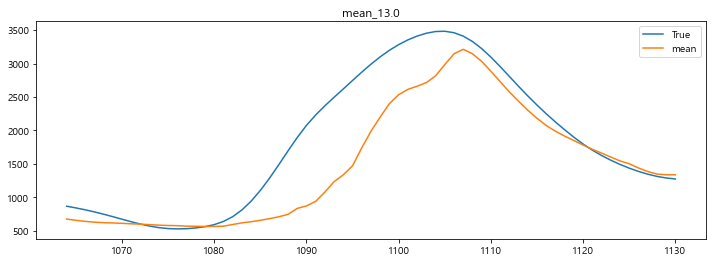

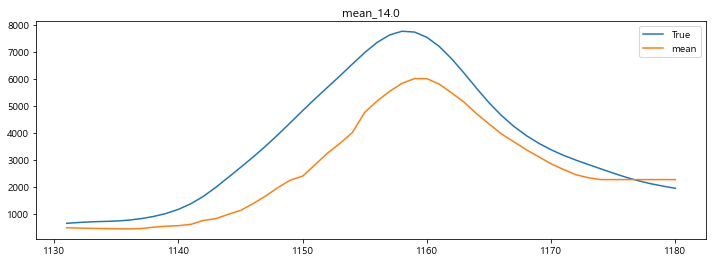

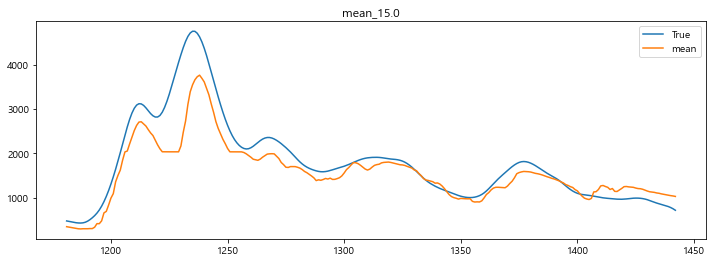

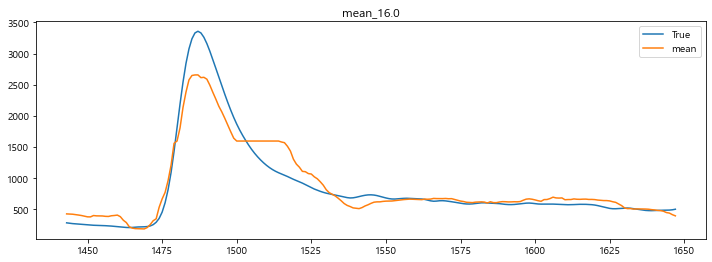

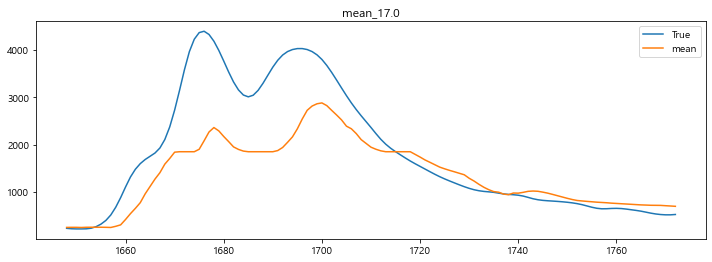

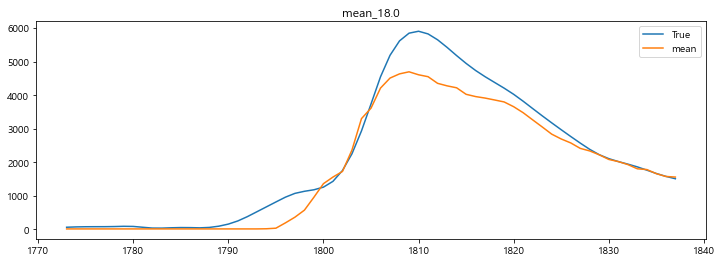

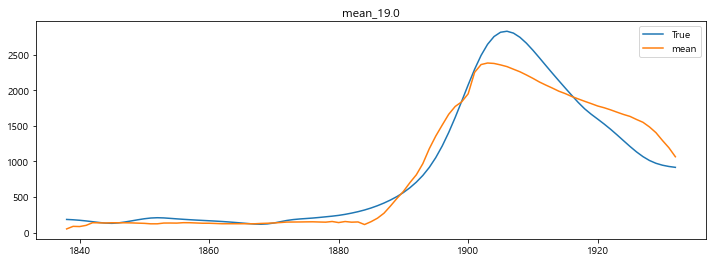

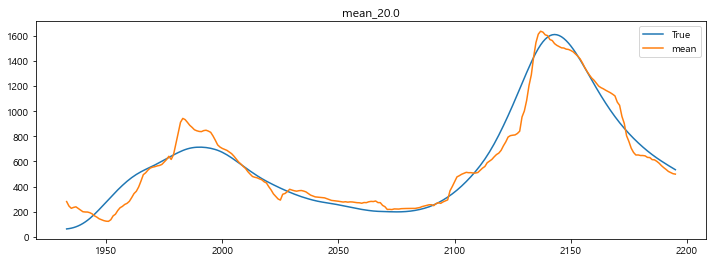

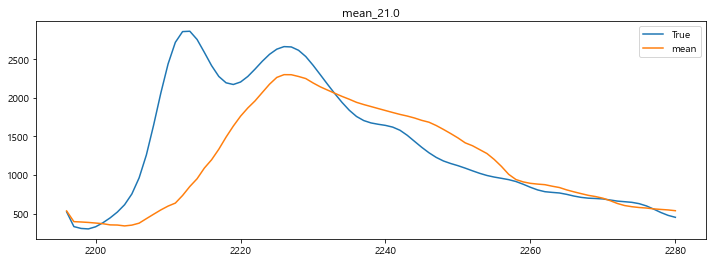

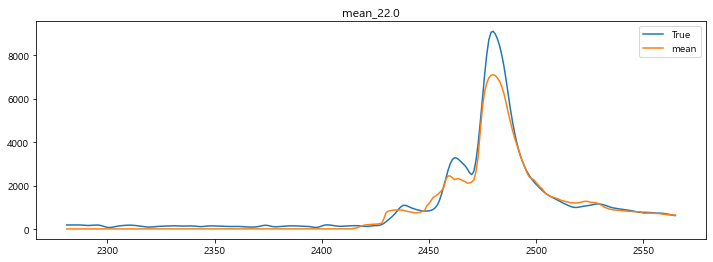

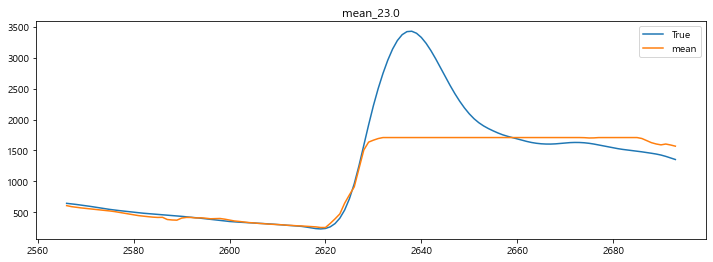

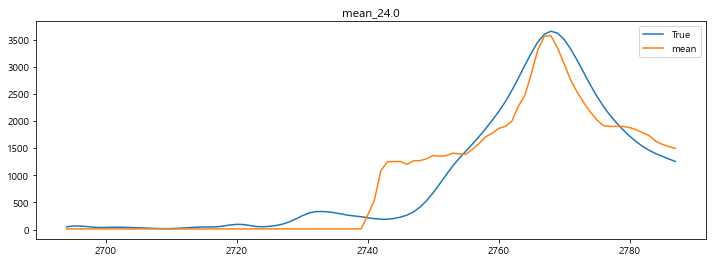

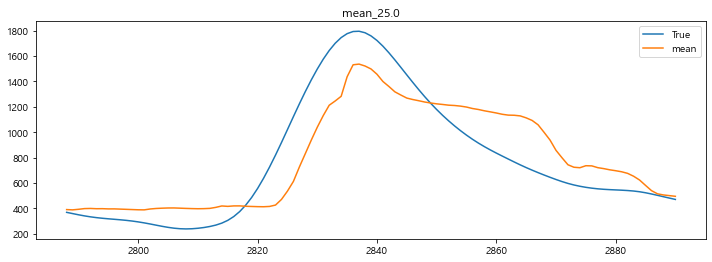

In [117]:
plot_hongsunum(predict_df, name)

## 5 8 16 제외

In [118]:
name = 'mean_586'

model_structure = {
    "num_epochs" : 5000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

data_one = pd.read_excel('../data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])
data_one = data_one.dropna()
data_one.columns = [col[1] if "Unnamed" not in col[1] else col[0] for col in data_one.columns.values]
data_one = data_one.groupby(by=data_one.columns, axis=1).mean()

data_one_589 = data_one[~data_one.홍수사상번호.isin([5,8,6])]

In [119]:
predict_df, rmse = dnn_predict(name, data_one_589, model_structure, robust_scaler, view=False, early_stop_num=10)

홍수사상번호 1.0 시작
Best Epoch: 1443 Best Valid Loss: 10369434.00

홍수사상번호 2.0 시작
Best Epoch: 1870 Best Valid Loss: 3488716.75

홍수사상번호 3.0 시작
Best Epoch: 3030 Best Valid Loss: 65296.73

홍수사상번호 4.0 시작
Best Epoch: 2509 Best Valid Loss: 328206.88

홍수사상번호 7.0 시작
Best Epoch: 2222 Best Valid Loss: 1242188.00

홍수사상번호 9.0 시작
Best Epoch: 1788 Best Valid Loss: 196412.39

홍수사상번호 10.0 시작
Best Epoch: 2197 Best Valid Loss: 36194.25

홍수사상번호 11.0 시작
Best Epoch: 1993 Best Valid Loss: 305618.31

홍수사상번호 12.0 시작
Best Epoch: 3438 Best Valid Loss: 335664.44

홍수사상번호 13.0 시작
Best Epoch: 1820 Best Valid Loss: 452232.75

홍수사상번호 14.0 시작
Best Epoch: 1943 Best Valid Loss: 1407141.75

홍수사상번호 15.0 시작
Best Epoch: 1529 Best Valid Loss: 276376.25

홍수사상번호 16.0 시작
Best Epoch: 2856 Best Valid Loss: 38960.39

홍수사상번호 17.0 시작
Best Epoch: 1911 Best Valid Loss: 683715.38

홍수사상번호 18.0 시작
Best Epoch: 1886 Best Valid Loss: 201136.64

홍수사상번호 19.0 시작
Best Epoch: 2086 Best Valid Loss: 38582.29

홍수사상번호 20.0 시작
Best Epoch: 1023 Best Valid Lo

In [120]:
data_one_589

,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(D지역),수위(E지역),시간,연,월,유역평균강수,유입량,일,홍수사상번호
0,7.00,7.00,7.50,8.00,122.60,2.54,8.00,2006.00,7.00,6.37,189.10,10.00,1.00
1,7.00,8.00,8.50,9.00,122.60,2.53,9.00,2006.00,7.00,6.83,216.95,10.00,1.00
2,7.00,9.00,8.67,9.50,122.59,2.53,10.00,2006.00,7.00,7.60,251.42,10.00,1.00
3,8.00,10.00,11.67,11.33,122.59,2.53,11.00,2006.00,7.00,9.60,302.81,10.00,1.00
4,10.17,12.00,13.67,13.17,122.59,2.53,12.00,2006.00,7.00,12.33,384.78,10.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,6.00,0.00,1.00,1.00,137.14,3.03,18.00,2017.00,7.00,8.07,513.37,18.00,25.00
2887,2.00,0.00,1.00,1.00,137.15,3.00,19.00,2017.00,7.00,4.06,502.85,18.00,25.00
2888,1.00,0.00,1.00,1.00,137.16,2.98,20.00,2017.00,7.00,3.00,491.95,18.00,25.00
2889,1.00,0.00,1.00,1.00,137.17,2.96,21.00,2017.00,7.00,2.72,481.10,18.00,25.00


In [121]:
rmse_df.loc[name, "RMSE"] = rmse
rmse_df

,RMSE
base,502.05
mean,1128.37
mean_586,1116.86


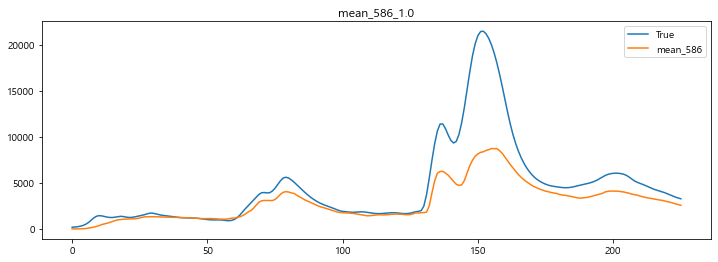

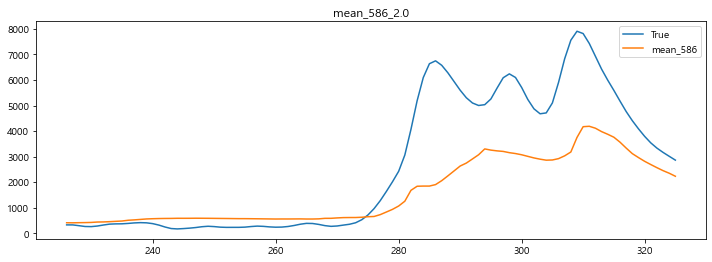

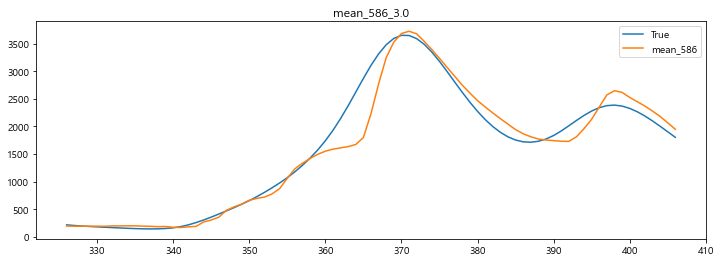

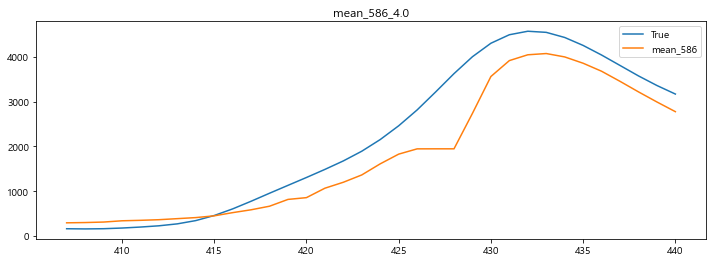

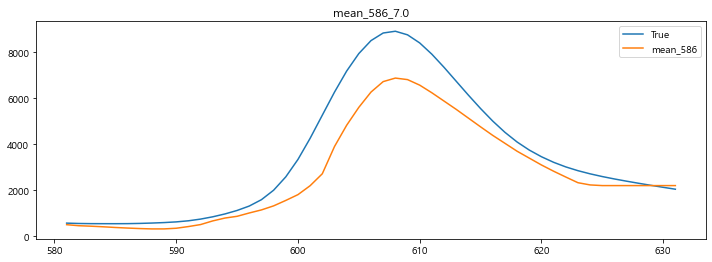

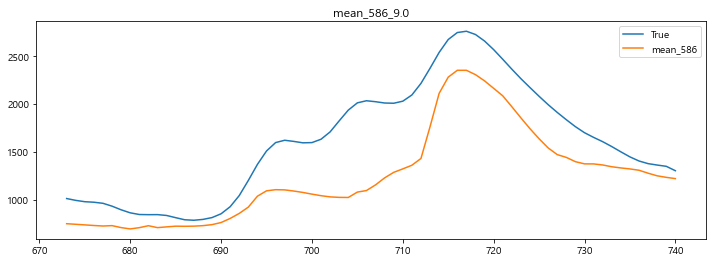

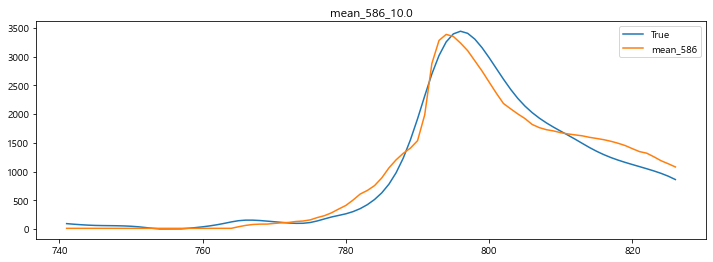

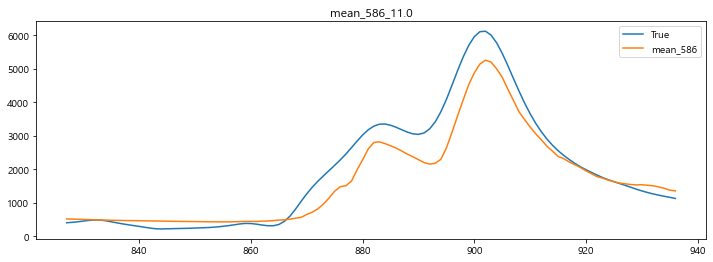

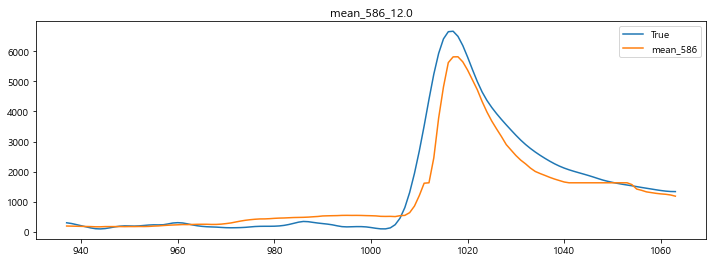

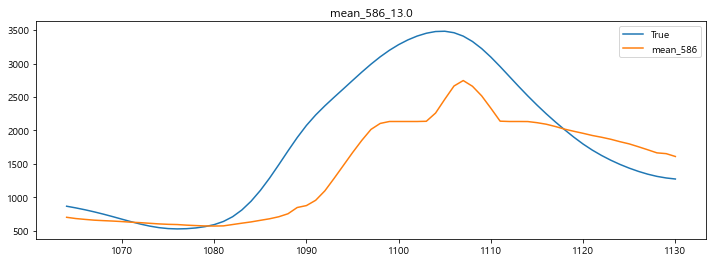

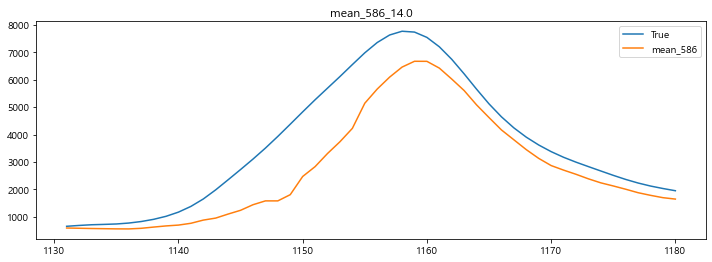

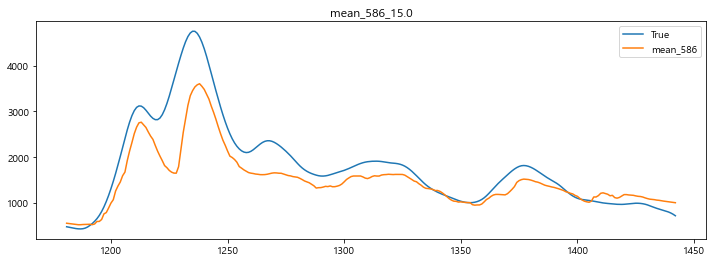

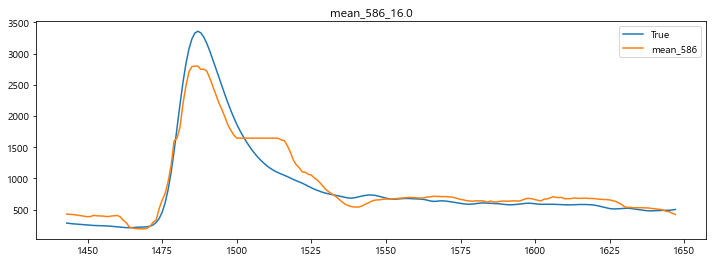

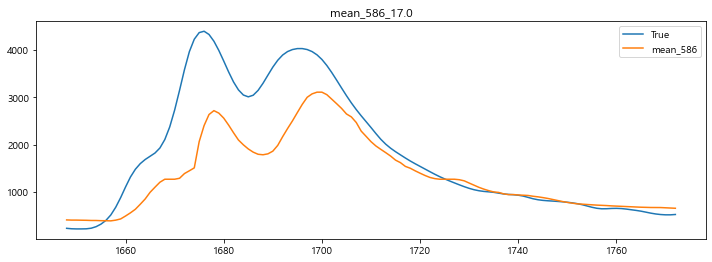

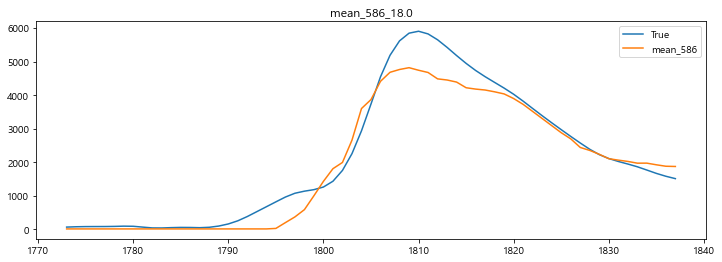

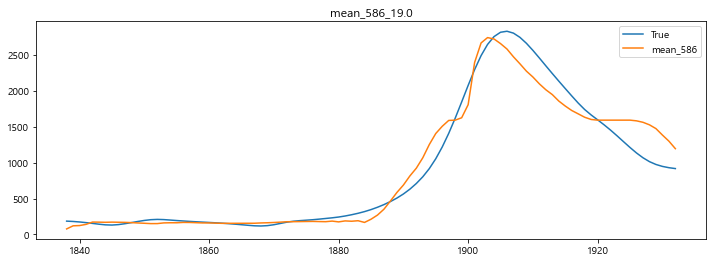

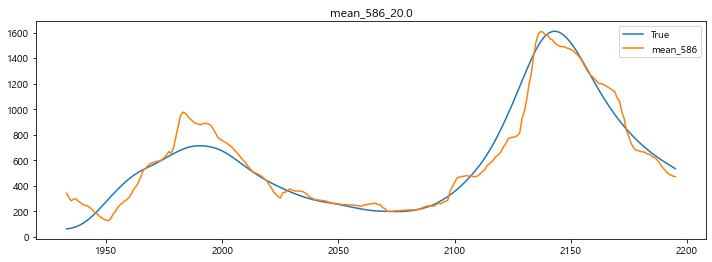

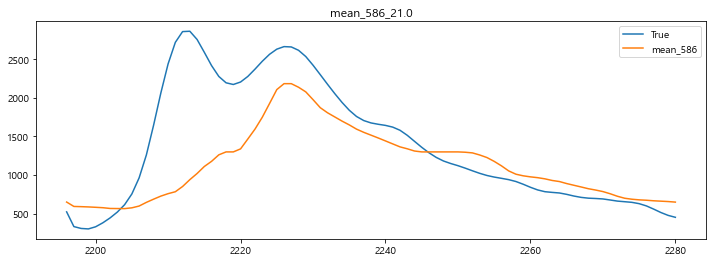

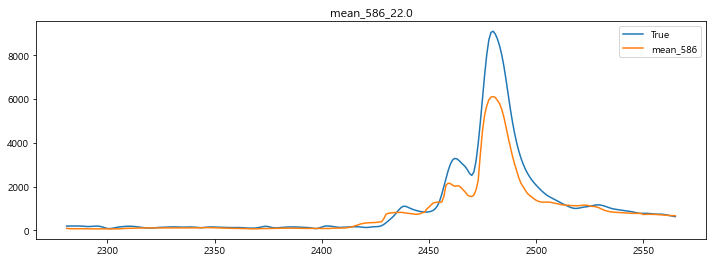

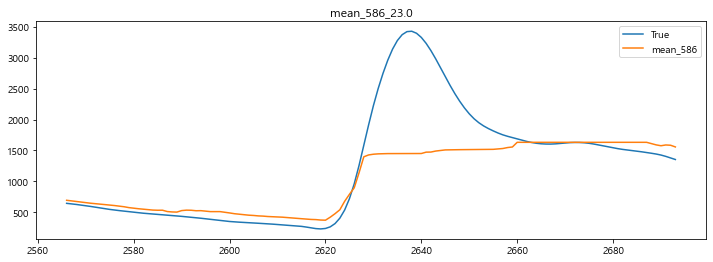

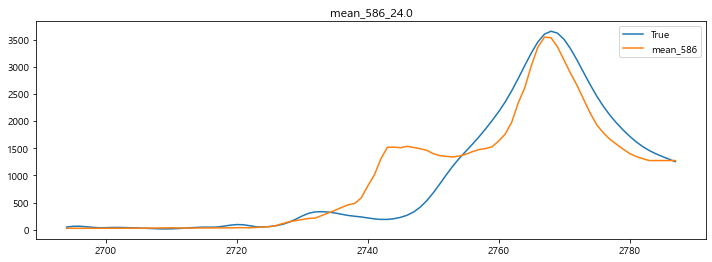

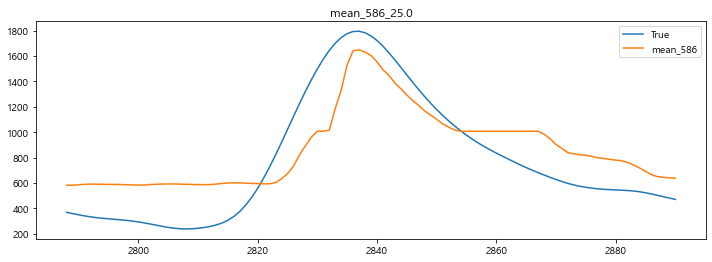

In [122]:
plot_hongsunum(predict_df, name)